# Lab Report: Classification with k-Nearest Neighbour Algorithm
## Example 1: Improving Matches for A Dating Site with KNN
### 1.1 Data Processing
This part will load data from the file, then normalize the data.

#### 1.1.1 file2matrix
In each line of the data file given by Helen, first three numbers representing the feature of data object, while the fourth represents the label. The `file2matrix` function is being used to load the original feature and label from file.
It first use python built-in `open` function to load the file. `fr` is a `TextIoWrapper` object, it has `readlines()` method that can return `list` containing string for each line. `len` method is used to count number of lines, so that we can initialize a ndarray having proper size to store the data. We iterate the list storing the line strings, in order to extract the feature value and write to original feature matrix and class_label_vector. And finally, it returns the original feature matrix and class label vector

***Input params***: The string filename inciting the path of the data file.
***Output***: The original feature matrix  with each row representing the data point - return_mat (ndarray), and the label vector - class_label_vector(python list).

The detail explanations for each line of file2matrix are written in line comments of following code cell.

In [64]:
from numpy import *
import operator
# numpy.set_printoptions(threshold=np.inf)

def file2matrix(filename):
    # Load the file with given filename, and store in the variable fr
    fr = open(filename)
    #fr.readlines() read the txt file to list, the len method counts lines in the file,
    number_of_lines = len(fr.readlines())
    # define a 2d numpy array , to store the coordinate of the data points x
    return_mat = zeros((number_of_lines, 3))
    # used to store the label of data points, y
    class_label_vector = []
    index = 0
    # here we  open the file repeatedly for reason
    # If we do not open the file again we will get nothing from fr.readlines()
    # As the previous fr.readlines() has move file pointer to the end of the file.
    fr = open(filename)
    for line in fr.readlines():
        #trim the spaces at the head and tail of each lines
        line = line.strip()
        # the data points are divided using tab,
        # split the string, and extract tokens from the line-string
        list_from_line = line.split('\t')
        # the first three numbers are the original features
        return_mat[index, :] = list_from_line[0:3]
        # last number is the feature, stored in the class_label_vector
        class_label_vector.append(int(list_from_line[-1]))
        #the index is used to keep track of the row number, write to return_mat sequentially
        index += 1
    #return the original feature matrix and class label vector
    return return_mat, class_label_vector

Here we load matrix `datingDataMat` and class label vector from the training data file. And print the nparray to see if the data is loaded correctly.

In [65]:
datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
print("\n Original features")
print(datingDataMat)
print("\n Labels:")
#print first 20 labels
print(datingLabels[0:20])


 Original features
[[4.0920000e+04 8.3269760e+00 9.5395200e-01]
 [1.4488000e+04 7.1534690e+00 1.6739040e+00]
 [2.6052000e+04 1.4418710e+00 8.0512400e-01]
 ...
 [2.6575000e+04 1.0650102e+01 8.6662700e-01]
 [4.8111000e+04 9.1345280e+00 7.2804500e-01]
 [4.3757000e+04 7.8826010e+00 1.3324460e+00]]

 Labels:
[3, 2, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3]


#### 1.1.2 autoNorm
For the each feature from the training data, it has different scale. The classification will biased to the feature with larger scale if we do not normalize the features.
With AutoNorm function will normalize data using max-min normalization.
##### 1.1.2.1 Code and details
The input parameter is the original feature of data matrix. The  `min(0)` and `max(0)` will find out the minimum value and maximum value among all elements in each column (feature) of the data matrix. For the max function, without parameter it will find out the maximum element in the whole matrix. If we use 0 as parameter it will find out the max value in each column while using 1 in each row, and return array of max values. The minVals and maxVals are ndarray with length of 3 containing the maximum and minimum values of each column. The minVals - maxVals will conduct element wise operation on the ndarray.`ranges` contains the range of each feature (max - min). The `shape` function of ndarray will return shape of the ndarray in tuple format (rows, columns). We can obtain the number of rows using `dataset.shape[0]`. The `tile` function is being used to construct ndarray with repeated given component. The second parameter of  `tile` function, is array-like, indicates how many times the given ndarray(or a single number) is being repeated along each axis.`tile(minVals, (m,1))` will construct a matrix with `minVals` repeat m time along axis=0 and 1 times along axis=1, which is a matrix with m `minVal` row vectors stacked. It has same shape as `dataset` matrix. Operator can be directly applied to ndarray with homo shape to conduct elementwise operation.
```python
    normDataset = dataset - tile(minVals, (m, 1))
    normDataset = normDataset / tile(ranges, (m, 1))
```
Those two lines apply element wise operation on the the the dataset. The normDataset is the result of each element of datamatrix being max-min normalized. At the end, we return the result of, of normalized dataset matrix, and ranges and minVal vectors.

***Input params***: original feature matrix to be normalized, ndarray.
***Output***:  normalized feature matrix, ndarray. The vector with each element represent the range of each feature. The minVals vector representing the minimal value of each feature:

The ranges and minVals will be used to normalized the testing dataset.



In [66]:
def autoNorm(dataset: ndarray):
    minVals = dataset.min(0)
    maxVals = dataset.max(0)
    ranges = maxVals - minVals
    normDataset = zeros(shape(dataset))
    m = dataset.shape[0]
    normDataset = dataset - tile(minVals, (m, 1))
    normDataset = normDataset / tile(ranges, (m, 1))
    return normDataset, ranges, minVals


Print some of loaded features

In [67]:
normMat, ranges, minVals = autoNorm(datingDataMat)
print('\n Normalized features:')
print(normMat)


 Normalized features:
[[0.44832535 0.39805139 0.56233353]
 [0.15873259 0.34195467 0.98724416]
 [0.28542943 0.06892523 0.47449629]
 ...
 [0.29115949 0.50910294 0.51079493]
 [0.52711097 0.43665451 0.4290048 ]
 [0.47940793 0.3768091  0.78571804]]


### 1.2 Classification
Here, will be the core part of this report. Classification using kNN algorithm. The basic idea of KNN algorithm is: with a newly given data point to predict, in the training set we find k closest data points to the new data point and do a majority vote on labels of those k data points to determine the label of the newly given data point.

#### 1.2.1 classify0
The classify0 function will first calculate the distance of the given new data point to rest of the data points stored in a list. Using `argsrot` to find k nearst data points. The loop iterate the count the frequency of labels in those k neighbours. Then we sort the label frequent dictionary in descending order to obtain the most frequent label as the classification result.

***Input params***: `inX` - The testing data vector, representing a single data point, it should be normalized using the `range` and the `minVals` vector. `dataset` is the normalized feature matrix.
***Output***: The predicted label of the given testing datapoint.

In [68]:
def classify0(inX: ndarray, dataset: ndarray, labels: list, k):
    # number of data points in the dataset matrix
    datasetSize = dataset.shape[0]
    # first construct a same size matrix as the data set matrix by staking
    # the testing point repeatedly, and then subtract dataset matrix elementwise
    diffMat = tile(inX, (datasetSize, 1)) - dataset
    #squre the difference
    sqDiffMat = diffMat ** 2
    # sum up
    sqDistances = sqDiffMat.sum(axis=1)
    # root the squire sum get the euclidean distance
    distances = sqDistances ** 0.5
    #argsort the distance in order to get indices of k nearst neighbours
    sortedDistIndices = distances.argsort()
    classCount = {}
    for i in range(k):
        # get the labels of first k neighbours
        vote_labels = labels[sortedDistIndices[i]]
        # count the labels
        classCount[vote_labels] = classCount.get(vote_labels, 0) + 1
        #using the count frequency sort the class count dictionary in descending order,
        # which obtain list of tuples (tuple is the key value pair of the classCount dictionary)
        sorted_class_count = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    #return the class count, which is the label with the largest count
    return sorted_class_count[0][0]

#### 1.2.2 classifyPerson
This function simply assemble all the functions before to perform the classification task for the dating site. It first get data point from user, then call `file2matrix` to load the training dataset file to matrix. `AutoNorm` will not only normalize the original feature matrix, its return value `range` and `minVals` will be used to normalize the input vector. Passing training data and and testing vector, classification will be done by `classify0`.

***Input***: The three features of testing data point, to make something different from the lab manual, the feature is [49459,8,0.5]
***Output***: The predicted result of the testing data point with given training dataset.

In [69]:
def classifyPerson():
    # The label name corresponding to the number label
    resultList = ['not at all', ' in small doses', 'in large doses']
    # Following three lines requesting user input to obtain the features of the tesing datapoint
    ffMiles = float(input('\n Feature 1:'))
    percentTats = float(input("\n Feature 2:"))
    iceCream = float(input("\n Feature 3:"))
    # get the original feature matrix and label from file
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
    #normalize the oringal label matrix, get the max-min range vector and minVals vector
    normMat, ranges, minVals = autoNorm(datingDataMat)
    # convert the input feature values to vector
    inArr = array([ffMiles, percentTats, iceCream])
    # normalize the input testing data point vector, do then do the classification
    classifier_result = classify0((inArr - minVals) / ranges, normMat, datingLabels, 3)
    # print the classification result
    print(inArr)
    print("\n You will probably like this person: ", resultList[classifier_result - 1])


classifyPerson() # [49459,8,0.5] in large dose
classifyPerson() # [10000,10,0.5] in small dose

[1. 1. 1.]

 You will probably like this person:   in small doses
[1. 1. 1.]

 You will probably like this person:   in small doses


## Example 2: A Handwriting Recognition System

### 2.1 Data Processing
The hand written digits are stored in the txt file, and only have binary degree of color. This part will load the hand written digit to vector. **Here, I add new one more function myself, which is the visualize_digit.** The visualize_digit is used to visualize the hand written digit so that we can more clearly see if the data is loaded correctly. Also we can use it to visualize some of those misclassified digits.
#### 2.1.1 visualize_digit
A simple function for visualizing the hand written digits.

***Input params***: The 1d image vector, 1024 in length
***Output***: Visualized hand written digit.

In [70]:
from os import listdir
from numpy import *
import matplotlib.pyplot as plt


def visualize_digit(digit_vec: ndarray, title='Hand Written Digit'):
    #define the size of the figure
    fig = plt.figure(figsize=(6, 3.2))
    # reshape the 1d vector to a 32*32 vector
    digit_vec = digit_vec.reshape((32, 32))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    plt.imshow(digit_vec, cmap='gray', vmin=0, vmax=1)
    ax.set_aspect('equal')
    plt.colorbar(ax=ax, orientation='vertical')
    plt.show()

#### 2.1.2 img2Vector
This block of code is used to load the hand written digit array from file. And it will return a 2d array, with only one row along axis=0, ane 1024 columns along axis=1.

Here to mention the advance indexing of the ndarray.
```python
 ndarray[rows, cols]
```
If using single number of row or single number of col, it is equivalent to the `ndarray[row][col]`. Using array like `rows` and `cols`, it will return the indexed element array with same shape as rows array.

***Input:*** The file path.
***Output:*** THe image vector, the shape is (1,1024)


In [71]:
def img2Vector(filename):
    # initialize array with one row along axis 0 and 1024 columns along axis = 1
    returnVect = zeros((1, 1024))
    fr = open(filename)

    # The digit matrix stored in the file is 32*32 format, we need to iterate through
    # to flatten the 32*32 matrix to 1*1024 matrix
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0, 32 * i + j] = int(lineStr[j])
    return returnVect

Print the first 32 digits of the loaded vector and the digit image.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


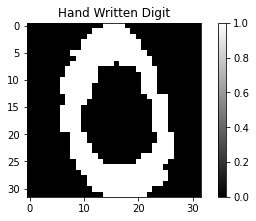

In [72]:
print(img2Vector("testDigits/0_13.txt")[0][0:32])
visualize_digit(img2Vector("testDigits/0_13.txt")[0])

#### 2.1.2 formulateTrainingData
The img2Vector is used to load single digit file. The `formulateTrainData` will load all the training digit in batch. If we have `m` training samples, it will return a $\mathbb{R}^{m\times 1024}$ matrix staking all images vectors. The label for the digit images is in the file name. By splitting the file name string, we can obtain the label for the given digit image. `listdir` is the function that load the directory filenames to a list. Using the filename list, the digit images and label can be loaded. The detailed explanation for the code is written in the line comment.

***Input:*** No input from the parameter or console. The digits to be load is under the trainingDigits directory.
***Output:*** The ndarray with shape of (m,1024), m is the number of digits loaded.


In [73]:
def formulateTrainingData():
    hwLabels = []
    #obtain filename list
    trainingFilelist = listdir('trainingDigits')
    # get number of digit files to load the image to the list
    m = len(trainingFilelist)
    # initialize an ndarray to store the image vectors
    trainingMat = zeros((m, 1024))
    for i in range(m):
        fileNameStr = trainingFilelist[i]
        #omit file extension
        fileStr = fileNameStr.split('.')[0]
        #get label
        classNumStr = int(fileStr.split('_')[0])
        #append label to list
        hwLabels.append(classNumStr)
        # add image vector to row i of the data matrix
        trainingMat[i, :] = img2Vector('trainingDigits/%s' % fileNameStr)
    return trainingMat, hwLabels


trainingMat, hwLabels = formulateTrainingData()

### 2.2 Classification
We can reuses the previous `classifiy0` to perform the classification task.
#### 2.2.1 handwritingClassTest
 This function will first load the training dataset, then load the test dataset. For each image in the test dataset, it will be passed to the `classify0` function to get the predicted label. By comparing the true label and predicted label, we will know if the image is misclassified. The function will count the number of misclassified images, and after classify all the images, it calculates the error rate.

***Input:*** The trainingMat is a (m,1024) ndarray with each row is the handWritten digit vector. hwLabels is the ture label of the hand written digit correspond to each row of the trainingMat.
***Output:*** `false_labels` : the misclassified labels, `misclassified_images`: image vector of misclassified digits, `true_lable`: true label of the misclassified digits. The console will output the error count and the error rate by errorCnt/TestNum
The return value will be used later to visualize those misclassified digits.

In [74]:
def handwritingClassTest(trainingMat, hwLabels):
    # get the filename list for the testing dataset
    testFileList = listdir('testDigits')
    errorCount = 0.0
    mTest = len(testFileList)

    misclassified_images = []
    false_labels = []
    true_labels = []

    for i in range(mTest):
        # get the testing vector and its label
        fileNameStr = testFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        vectorUnderTest = img2Vector('testDigits/%s' % fileNameStr)

        # pass the vector under test and training dataset to predict the result
        classifierResult = classify0(vectorUnderTest, trainingMat, hwLabels, 3)

        # check if the vector is misclassified, if so, count error
        # and record the image vector, true label and misclassified label
        if classifierResult != classNumStr:
            errorCount += 1.0
            misclassified_images.append(vectorUnderTest[0])
            false_labels.append(classifierResult)
            true_labels.append(classNumStr)

    print(str(len(false_labels)))
    print("\n The total number of errors is: %d" % errorCount)
    print("\n The total error rate is %f" % (errorCount / float(mTest)))
    return false_labels, true_labels, misclassified_images


false_labels, true_labels, misclassified_images = handwritingClassTest(trainingMat, hwLabels)

10

 The total number of errors is: 10

 The total error rate is 0.010571


#### 2.2.2 Print misclassified digits
Using matplotlib to print some of those misclassified digits.

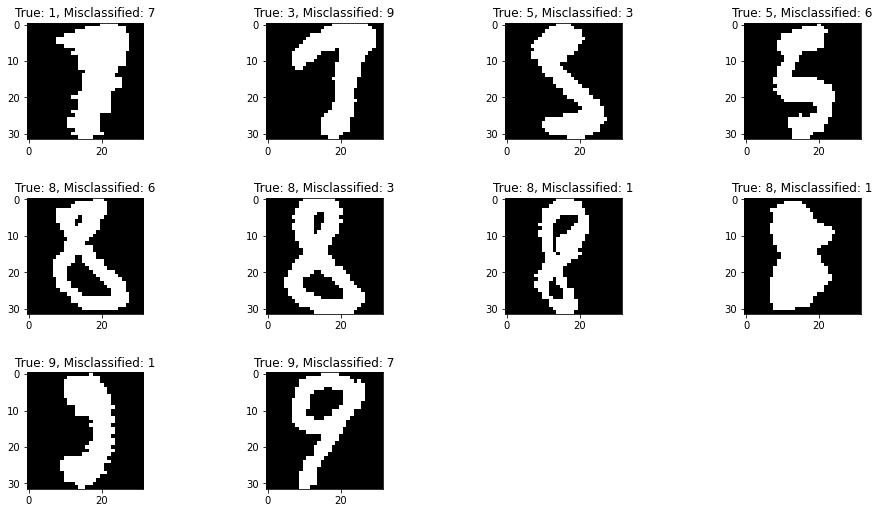

In [75]:
title = 'True: {}, Misclassified: {}'
fig = plt.figure(figsize=(15, 15))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=1)
columns = 4
rows = 5
for i in range(1,min(columns * rows + 1, len(misclassified_images)+1)):
    img = misclassified_images[i-1].reshape((32, 32))
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(title.format(true_labels[i-1], false_labels[i-1]))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)

plt.show()

## Exercise
Both training dataset and testing dataset are stored in the csv file.

<div>
<h6>Training Dataset:</h6>
<img height="190" src="exe_train.png" title="Training Dataset" width="450"/>
</div>

<div>
<h6>Test Dataset:</h6>
<img height="74" src="exercise_test.png" title="Execrise test dataset" width="371"/>
</div>

### 3.1 load_data
This method will load data from the csv file. And return data matrix and label. The last column of the file will be returned as label, and first 4 columns returned as features. So this single function can be used either to load train dataset with label or test dataset with features only. When load the test data set, we just simply ignore the `labels` return value.

***Input:*** The filename of the data to be load. It can be the path of either training data or testing data.
***Output:*** The data matrix with shape (m,4), where m is number of data points. Labels is the last column of the input file, which are labels if the file loaded are training dataset. If the input file loaded is test dataset, the labels vector is just the fourth feature, is useless and can be discarded.

Here, the implementation is basically the same as previous code, so I do not specify the functionality of the code line by line. (After all, I wrote following code myself)

In [76]:
def load_data(filename: str):
    f = open(filename)
    lines = f.readlines()
    dataMat = zeros((len(lines), 4))
    labels = []

    cnt = 0
    for line in lines:
        tokens = line.strip().split(',')
        labels.append(tokens[-1])
        dataMat[cnt, :] = float(tokens[0]), float(tokens[1]), float(tokens[2]), float(tokens[3])
        cnt = cnt + 1
    return dataMat, labels

### 3.2 Point classification
This function will load the data first, then normalize the training data and testing data. With previous defined KNN function `classify0`, classification will be performed. Return value `result` is the predicted label for testing points.

***Input:*** The file path of training data and testing data. k is the parameter for the kNN algorithm.
***Output:*** The label of the testing data point, with the sequence same as the datapoint in the testing data points file.

In [77]:
def classify_points(train_data_path: str, test_data_path: str, k: int):
    orig_dataset, labels = load_data(train_data_path)
    test_dataset = load_data(test_data_path)[0]
    #normlize training feature matrix
    norm_dataset, range_vec, min_vec = autoNorm(orig_dataset)
    #normalize test data point matrix
    norm_test_dataset = (test_dataset - tile(min_vec, (len(test_dataset), 1))) / tile(range_vec, (len(test_dataset), 1))
    result = []
    for point in norm_test_dataset:
        #Here the point is normalized, directly pass to the classify0 function
        predict = classify0(point, norm_dataset, labels, k)
        result.append(predict)
    return result

Print predict with k=3 and k=5, then print the prediction result.

In [78]:
predict_label_3 = classify_points(train_data_path='exercise_train.csv',
                                  test_data_path='exercise_test.csv',
                                  k=3)

predict_label_5 = classify_points(train_data_path='exercise_train.csv',
                                  test_data_path='exercise_test.csv',
                                  k=3)
print('k=3')
print(predict_label_3)
print('k=5')
print(predict_label_5)

k=3
['B', 'B']
k=5
['B', 'B']
